In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path

DATADIR = Path('./Data')

def detect_face(image):
    """returns a cutout of the subjects face as well as the rectangle around the subject"""
    face_cascade = cv2.CascadeClassifier("face-cascades/haarcascade_frontalface_default.xml")
    faces = face_cascade.detectMultiScale(image, scaleFactor=1.2, minNeighbors=5)

    if len(faces) != 1:
        return None, None

    (x, y, w, h) = faces[0]

    return image[y-50:y+h+50, x-50:x+w+50], faces[0]

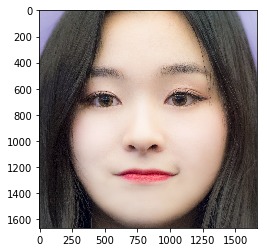

In [110]:
img = DATADIR / 'Gahyeon' / '3151.jpg'
img_array = cv2.imread(str(img))
color_img = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

face, rect = detect_face(color_img)
if face is not None:
    plt.imshow(face)
    plt.show()

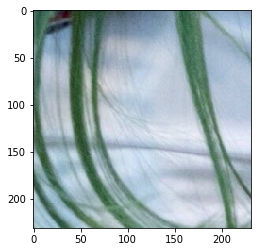

In [126]:
img = DATADIR / 'Gahyeon' / '4920.jpg'
img_array = cv2.imread(str(img))
color_img = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

face, rect = detect_face(color_img)
if face is not None:
    plt.imshow(face)
    plt.show()

In [112]:
import random

IMG_SIZE = 100

def a_generator():
    """a generator that randomly pulls images from the Data directory, processes them with cv2, and yields them"""
    gahyeon = iter((DATADIR / 'Gahyeon').iterdir())
    handong = iter((DATADIR / 'Handong').iterdir())
    data_dict = {0: gahyeon, 1: handong}
    name_dict = {'Gahyeon':0, 'Handong':1}
    for i in range(10410):
        r = random.randint(0, 1)
        try:
            p = next(data_dict[r])
        except StopIteration:
            p = next(data_dict[1-r])
        
        try:
            img_array = cv2.imread(str(p))
            color_img = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
            face, rect = detect_face(color_img)
            if face is not None:
                face = cv2.resize(face, (IMG_SIZE, IMG_SIZE))
                yield face, name_dict[p.parent.name]
        except Exception:
            pass
    return

In [113]:
import time

X = []
y = []

start_time = time.time()

for i, (features, label) in enumerate(a_generator(), 1): 
    X.append(features)
    y.append(label)
    
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(f"Found {i} faces in {time.time() - start_time:.4f} sec")

Found 6075 faces in 4058.8783 sec


In [114]:
import pickle

save_path = Path('./Models/Haar-cascade')

with open(save_path / 'X.pickle', 'wb') as file:
    pickle.dump(X, file)
    
with open(save_path / 'y.pickle', 'wb') as file:
    pickle.dump(y, file)

In [119]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
import pickle
import time

path = Path('./Models/Haar-cascade')

with open(path / 'X.pickle', 'rb') as X_file:
    X = pickle.load(X_file)
    
with open(path / 'y.pickle', 'rb') as y_file:
    y = pickle.load(y_file)
    
X = X / 255.0

name = f"3-conv-128-nodes-{int(time.time())}"

tensorboard = TensorBoard(log_dir=path / 'logs' / f"{name}")

model = Sequential()
model.add(Conv2D(128, (3, 3), input_shape = X.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

for i in range(2):
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

model.fit(X, y, batch_size=24, epochs=10, validation_split=0.05, callbacks=[tensorboard])

model.save(path / 'gahyeon-handong.model')

Train on 5771 samples, validate on 304 samples
Epoch 1/10
5771/5771 [==============================] - 9s 2ms/sample - loss: 0.5065 - acc: 0.7401 - val_loss: 0.2277 - val_acc: 0.9178
Epoch 2/10
5771/5771 [==============================] - 9s 2ms/sample - loss: 0.2414 - acc: 0.8959 - val_loss: 0.0889 - val_acc: 0.9605
Epoch 3/10
5771/5771 [==============================] - 9s 2ms/sample - loss: 0.1737 - acc: 0.9267 - val_loss: 0.0859 - val_acc: 0.9605
Epoch 4/10
5771/5771 [==============================] - 9s 2ms/sample - loss: 0.1343 - acc: 0.9421 - val_loss: 0.1125 - val_acc: 0.9638
Epoch 5/10
5771/5771 [==============================] - 9s 2ms/sample - loss: 0.1169 - acc: 0.9501 - val_loss: 0.1820 - val_acc: 0.9145
Epoch 6/10
5771/5771 [==============================] - 9s 2ms/sample - loss: 0.0920 - acc: 0.9586 - val_loss: 0.1102 - val_acc: 0.9671
Epoch 7/10
5771/5771 [==============================] - 9s 2ms/sample - loss: 0.0808 - acc: 0.9664 - val_loss: 0.1037 - val_acc: 0.9605
E

In [3]:
IMG_SIZE = 100

categories = ['Gahyeon', 'Handong']

path = Path('./Data/test')
            
X_test = []
y_test = []
            
for p in path.iterdir():
    try:
        img_array = cv2.imread(str(p))
        color_img = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        face, rect = detect_face(color_img)
        if face is not None:
            face = cv2.resize(face, (IMG_SIZE, IMG_SIZE))
            X_test.append(face)
            y_test.append(categories[int(p.name[0])])
    except Exception:
        pass

X_test = np.array(X_test).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

In [5]:
import tensorflow.keras.models

model = tensorflow.keras.models.load_model(Path('./Models/Haar-cascade/gahyeon-handong.model'))

prediction = model.predict([X_test])

correct = 0; gah_correct = 0; han_correct = 0
total = len(y_test); gah_total = len([i for i in y_test if i == "Gahyeon"]); han_total = total - gah_total

for p, actual in zip(prediction.flatten().tolist(), y_test):
    if categories[int(p)] == actual:
        correct += 1
        if actual == 'Gahyeon':
            gah_correct += 1
        else:
            han_correct += 1

print(f"""gahyeon: {{correct: {gah_correct}, total: {gah_total}, acc: {gah_correct/gah_total * 100:2.4f}%}}
handong: {{correct: {han_correct}, total: {han_total}, acc: {han_correct/han_total * 100:2.4f}%}}
overall: {{correct: {correct}, total: {total}, acc: {correct/total * 100:2.4f}%}}""")

gahyeon: {correct: 102, total: 104, acc: 98.0769%}
handong: {correct: 104, total: 114, acc: 91.2281%}
overall: {correct: 206, total: 218, acc: 94.4954%}
